# Pub Native case study

This notebook displays the **exploratory phase** of the case study as well as the machine learning training.

This phase is mandatory to build a proper predictive model.

I will start by taking a look at the **data types**, **distributions**, and **correlations**, then I will try out different models and compare their **precisions** as well as their **confusion matrices**.

## Exploration


First, lets look at the data at hand.

In [1]:
import pandas

import seaborn
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')


# A preliminary look at the csv showed the separator and the decimal representation.
training_csv = pandas.read_csv("./data/training.csv", sep=";", decimal=",")
testing_csv = pandas.read_csv("./data/validation.csv", sep=";", decimal=",")

In [2]:
(len(training_csv), len(testing_csv))

(3700, 200)

Since we don't have much data, a decision was made to test it on a small partition.
This means the model is subject to overfitting.

It was not the objective of the case study, but we could have discussed the partitioning of the data.

In [3]:
training_csv.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel
0,a,17.92,0.000054,u,g,c,v,1.750,f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,16.92,0.000034,y,p,k,v,0.290,f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,31.25,0.000112,u,g,ff,ff,0.000,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,48.17,0.000133,u,g,i,o,0.335,f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,32.33,0.000350,u,g,k,v,0.500,f,f,0,t,g,232.0,0,2320000.0,f,0,no.


We can already see that:
- The data is a mix of quantitative and qualitative variables.
- As expected, `classLabel` is the column of the data frames that contains the label of the data.
- Some variables can be `null`.


In [4]:
print(len(training_csv.columns))

19


In [5]:
variables = list(training_csv.columns[:-1])

# May be considered as overkill.
set(range(1, 20)).difference(set(list(map(lambda x: int(x.replace("v", "")), list(variables)))))

{16}

A malicious ninja removed the 16th variable of the data set!


<IPython.core.display.Javascript object>


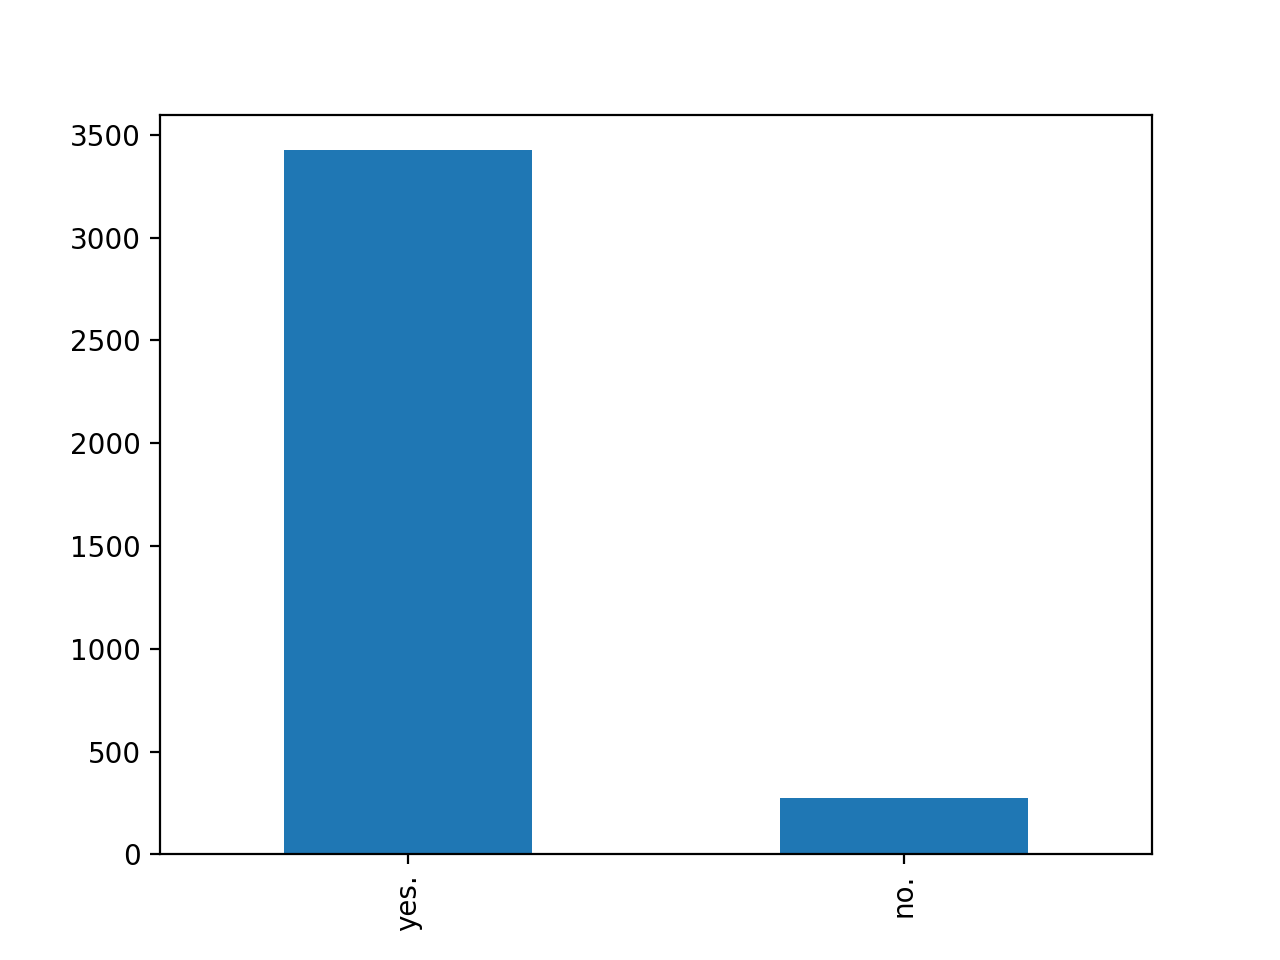

In [6]:
plt.figure()
training_csv.classLabel.value_counts().plot(kind="bar")

As we can see, the training set is biased.
It is clearly unbalanced with many more « yes. » than « no. ».
This can lead to serious overfitting and we have to take that into account when building the model.


<IPython.core.display.Javascript object>


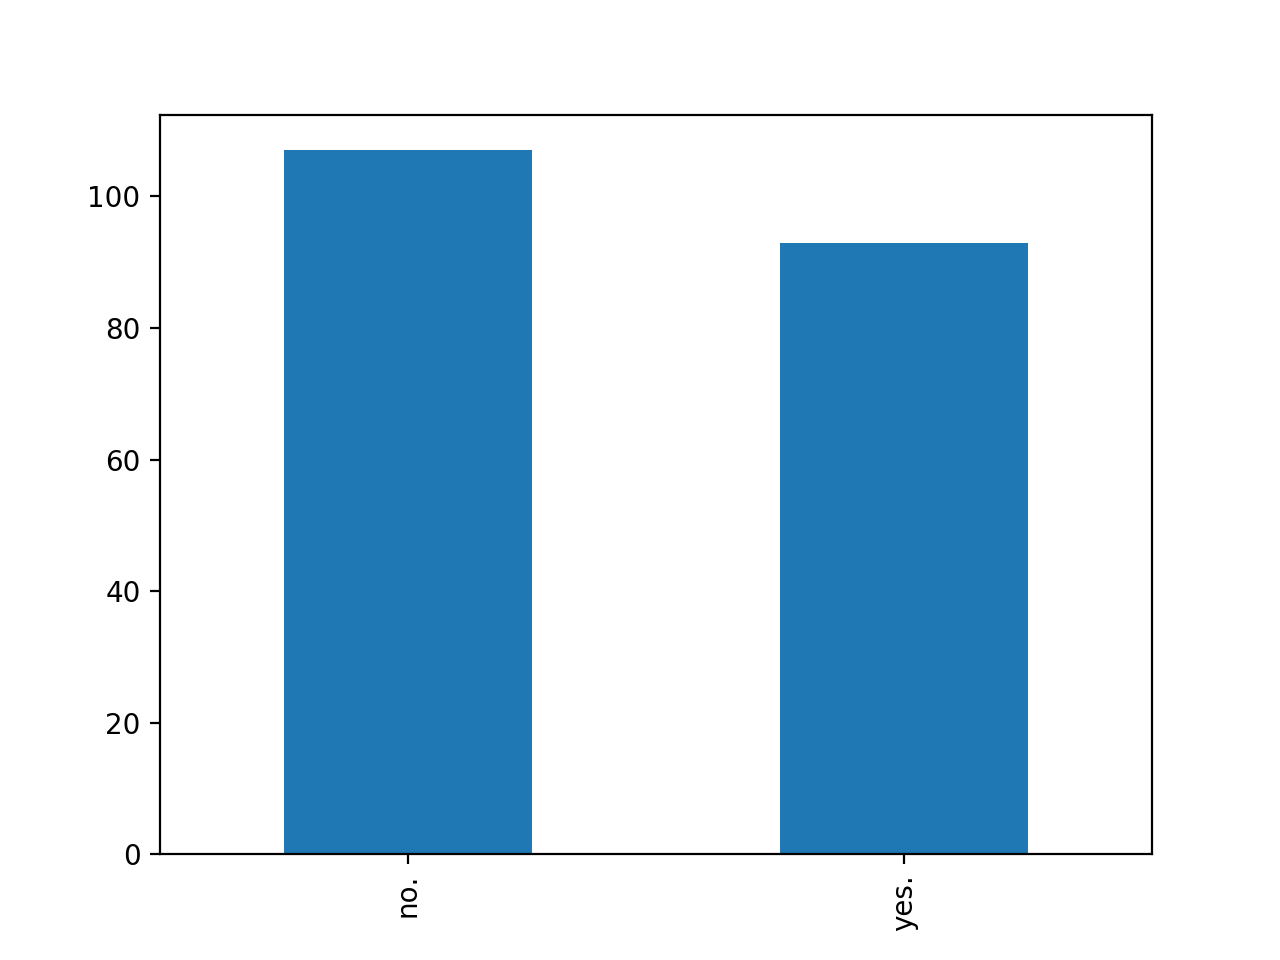

In [7]:
plt.figure()
testing_csv.classLabel.value_counts().plot(kind="bar")

On the other hand, the testing set is quite balanced.

## Pre-processing

The three main things we have to do now are:
- Encode the categorical variables.
- Standardize the quantitative variables.
- Deal with `NaN`s.

### Encoding the categorical variable


In [8]:
quantitatives = ["v2", "v3", "v8", "v11", "v14", "v15", "v17", "v19"]
qualitatives = list(set(variables).difference(set(quantitatives)))

In [9]:
training_data = training_csv[quantitatives]
testing_data = testing_csv[quantitatives]

training_csv[qualitatives].fillna("nan", inplace=True)
testing_csv[qualitatives].fillna("nan", inplace=True)

# To be used in the micro-service to encode incoming requests.
qualitatives_encoding_dictionnary = {q:{} for q in qualitatives}

def get_dict(df, column):
    """ Returns the encoding dictionnary for a data frame's column.
    """
    unique_values = list(df[column].unique())

    return {v: unique_values.index(v) for v in unique_values}


def encode(df, column, enc_dict=None):
    """Returns the encoded data frame of a data frame's column.
    
    If an encoding dictionnary is given, it is not re-computed.
    """
    if enc_dict is None:
        enc_dict = get_dict(df, column)

    n = len(enc_dict)
    enc_col_names = ["_".join([column, str(i)]) for i in range(1, n+1)]
        
    enc_data = []
        
    for v in df[column]:
        t = list(n*[0])
        t[enc_dict[v]] = 1
        enc_data.append(t)
    
    return pandas.DataFrame(enc_data, columns=enc_col_names), enc_dict


for q in qualitatives:
    enc_df, enc_dict = encode(training_csv, q)
    training_data = training_data.join(enc_df)
    
    qualitatives_encoding_dictionnary[q] = enc_dict
    
    enc_df, _ = encode(testing_csv, q, enc_dict=enc_dict)
    testing_data = testing_data.join(enc_df)

variables = training_data.columns
categoricals = list(set(variables).difference(set(quantitatives)))

Now, when building the micro-service, we will need to encode the incoming requests so that we can pass them through the model.
To do so, we will need the same dictionnary, else it makes no sense.
So we will save it as a json.


In [10]:
import json

with open("qualitatives_encoding_dictionnary.json", "w") as f:
    json.dump(dict(qualitatives_encoding_dictionnary), f)

### Dealing with quantitative null values

There can be many ways of dealing with null values.
They can be replaced with 0, the mean of the distribution, the median, or they can be discarded.

Since data is already scarce, we will replace the value with the median of the distribution.


In [11]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(training_data[quantitatives])

training_data[quantitatives] = imp.transform(training_data[quantitatives])
testing_data[quantitatives] = imp.transform(testing_data[quantitatives])

### Standardizing the distributions

Standardization is a requirement.
Since we want to apply the same transformations to the training set and the testing set, we will use the `StandardScaler` as it makes things easy.
It also eases the export to the micro-service, since incoming requests should be applied the same transformations.


In [12]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
scl.fit(training_data[quantitatives])

training_data[quantitatives] = scl.transform(training_data[quantitatives])
testing_data[quantitatives] = scl.transform(testing_data[quantitatives])

In [13]:
encode_labels = lambda x: 0 if x=="no." else 1

training_labels = training_csv["classLabel"].apply(encode_labels)
testing_labels = testing_csv["classLabel"].apply(encode_labels)

## Modeling


As we want to assess the quality of the model, we will need correllation matrices.
The following code (from sklearn's website) does just that.


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# From sklearn's website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def show_confusion_matrix(y_test, y_pred):
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=["no", "yes"], normalize=True,
                          title='Normalized confusion matrix')

Let's start with one of the easiest models, the linear regression.


In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(training_data, training_labels)

training_score = lr.score(training_data, training_labels)
testing_score = lr.score(testing_data, testing_labels)

print("Average validation score: {}\nTesting score: {}".format(training_score, testing_score))

Average validation score: 1.0
Testing score: -1.0299467390212005


The model performs perfectly on the training set, but is terrible on the testing set.
That shows us there must be a  serious bias in the data.

<IPython.core.display.Javascript object>


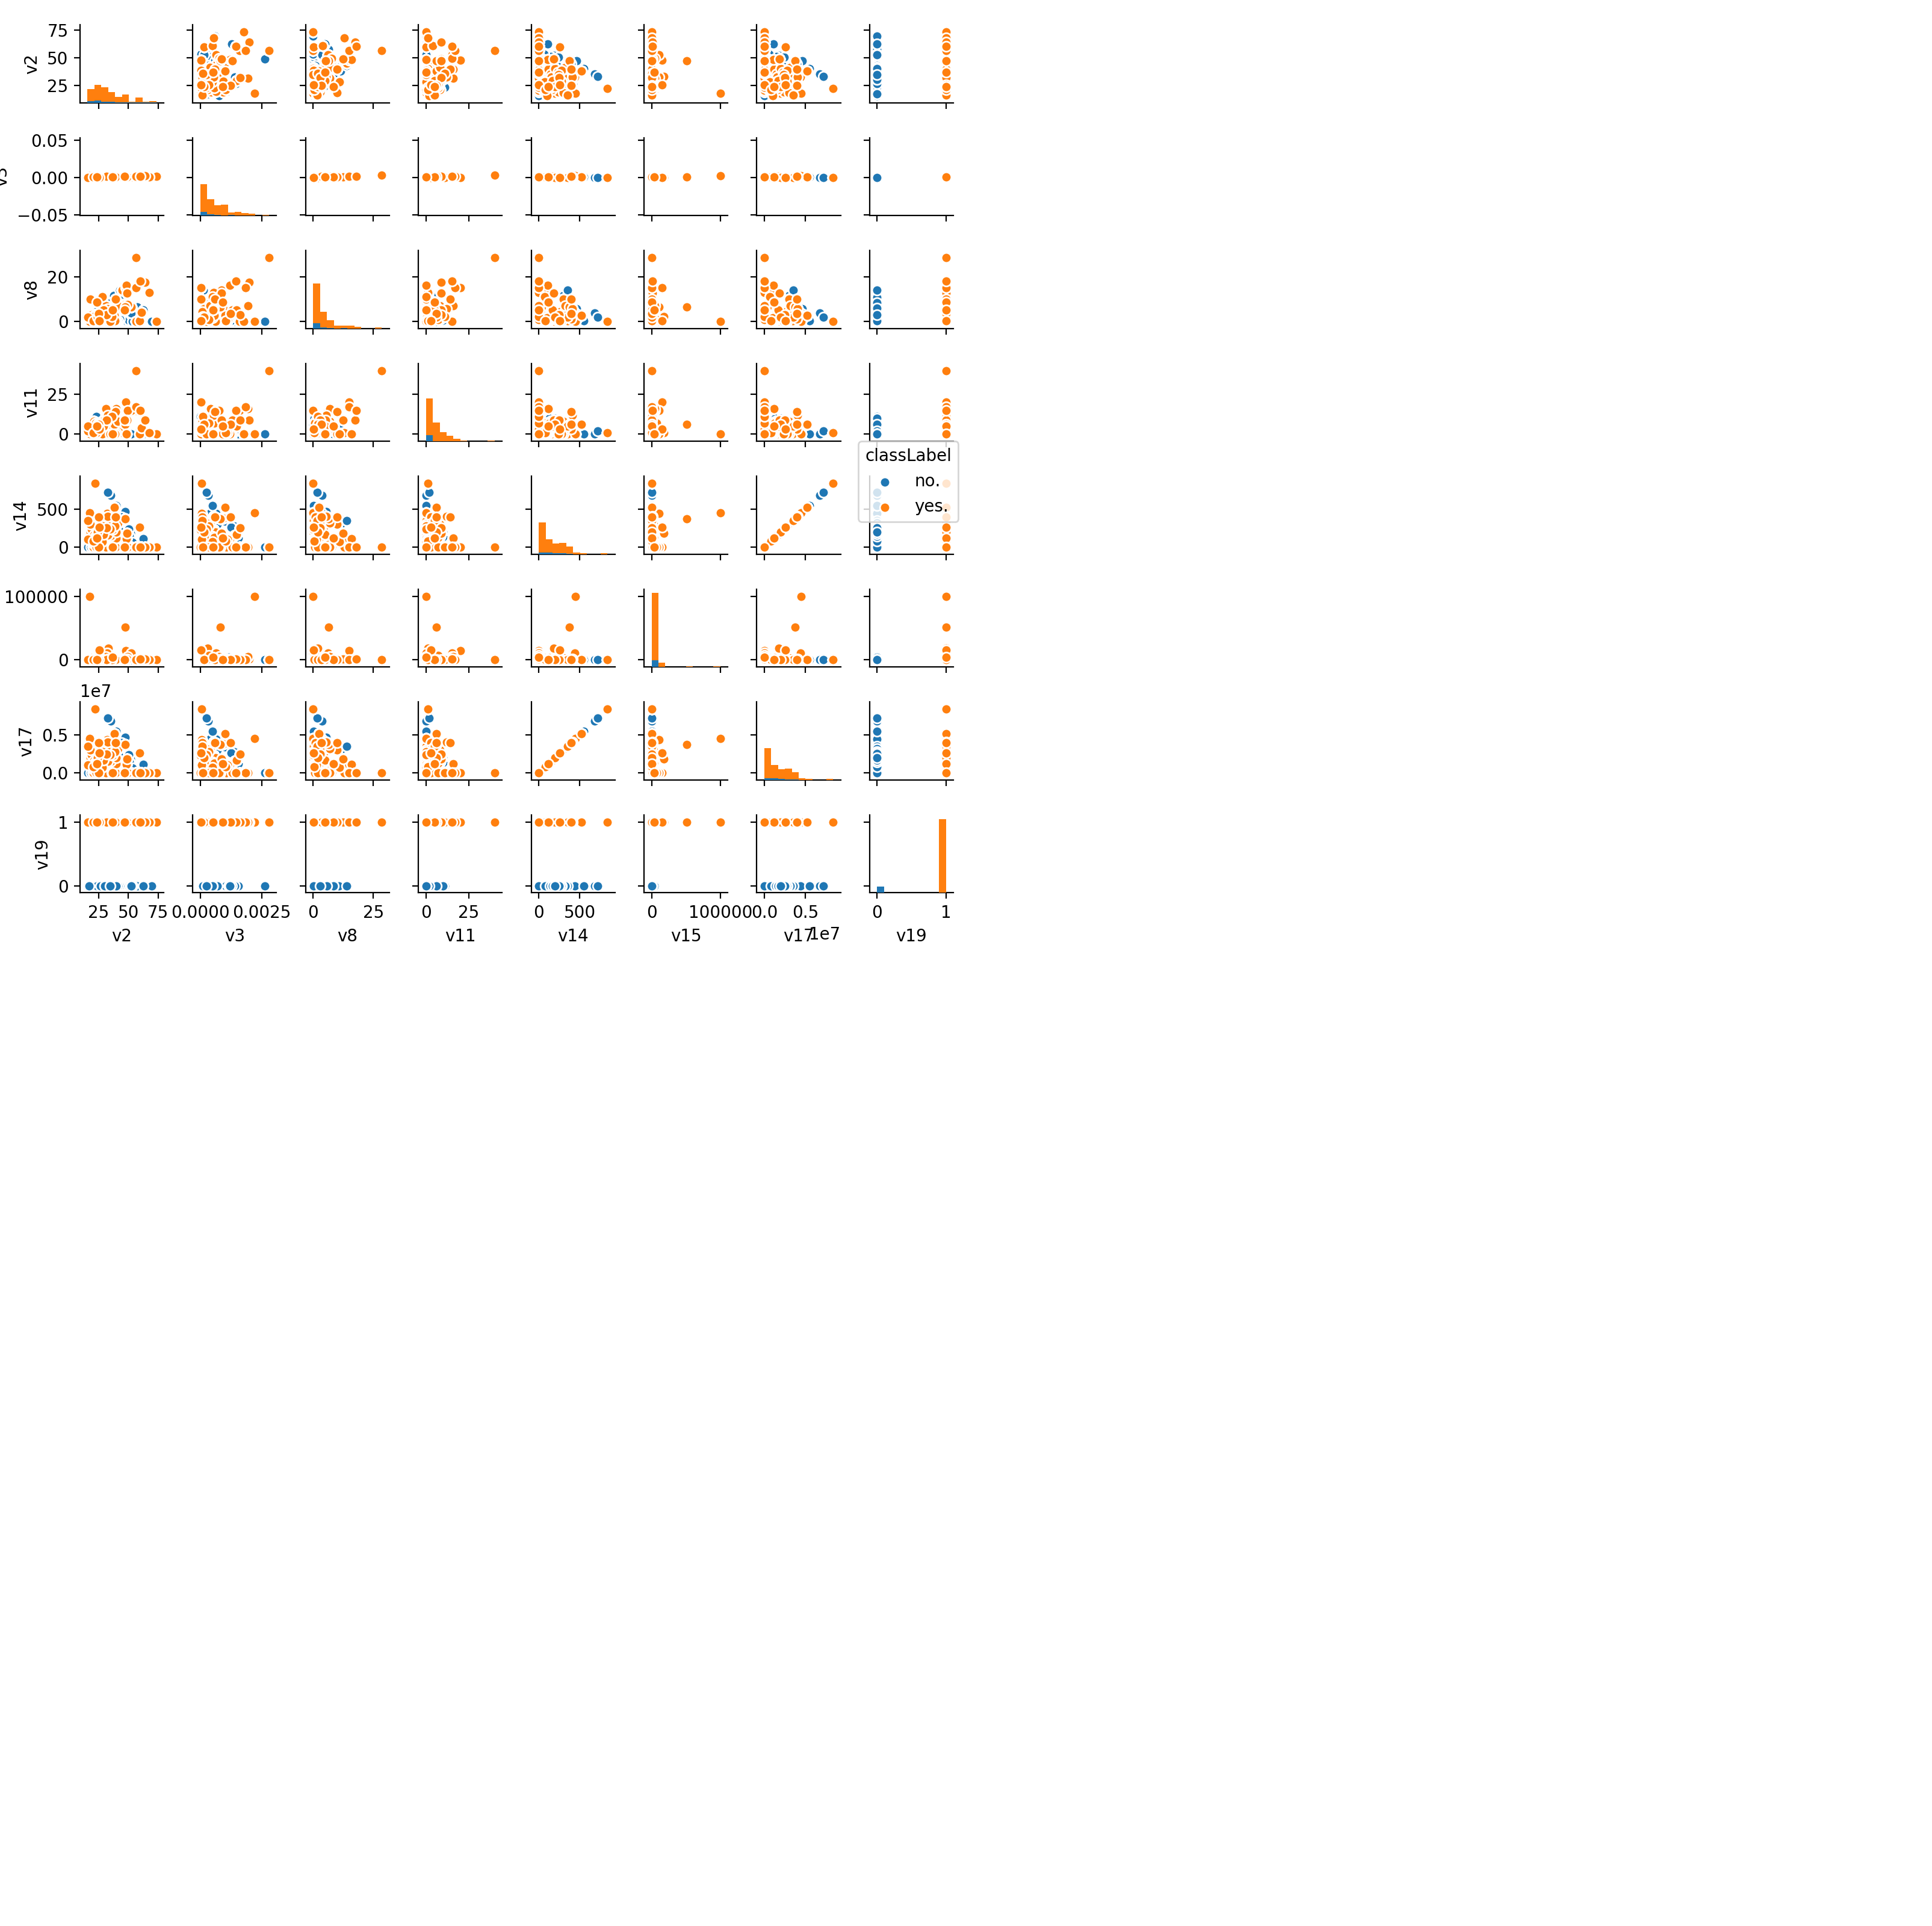

<IPython.core.display.Javascript object>


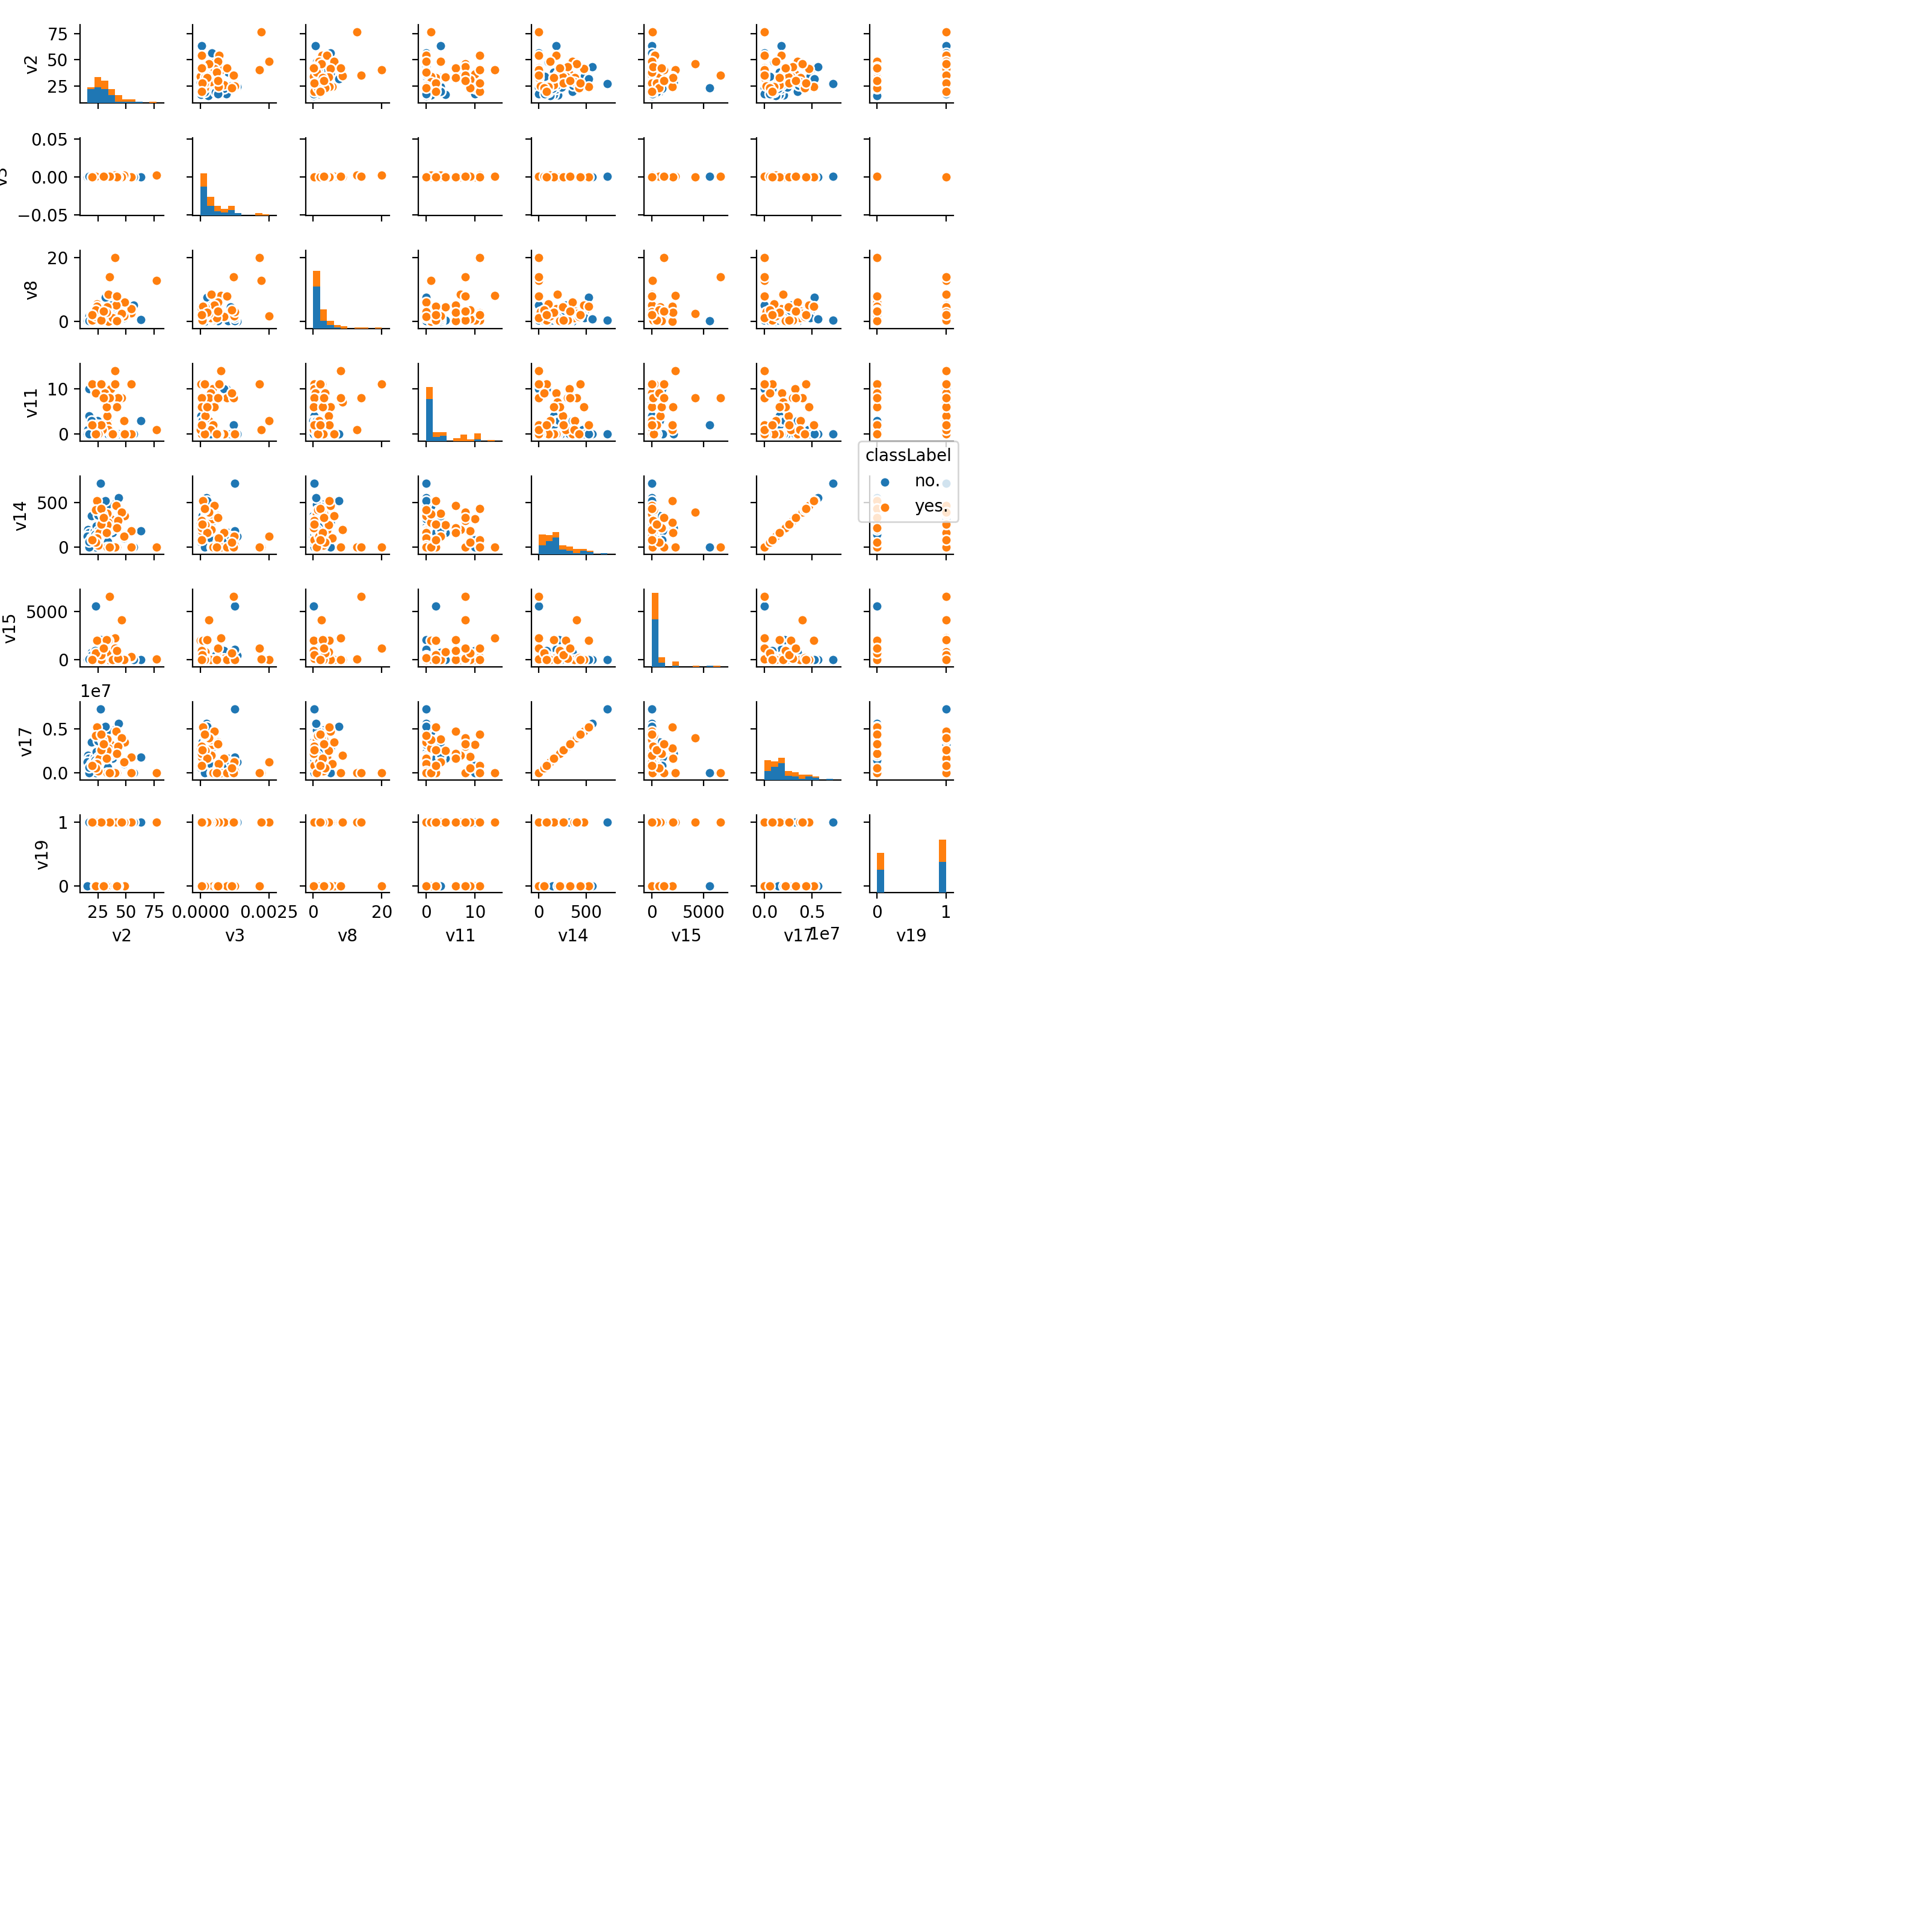

In [16]:
seaborn.pairplot(training_csv.dropna(), size=1, hue="classLabel")
seaborn.pairplot(testing_csv.dropna(), size=1, hue="classLabel")

There is a HUGE bias in the training set.

The `v19` variable is correlated with the output in the training set but not at all in the testing set.
This means that whatever model we build with that training set, the model will be biased into « thinking » that the `v19` has a direct impact on the outcome.

One solution would be to redo the partitionning so that we have examples in the training set that prove the correlation wrong.

Another would be to drop the variable all together.
This is frustrating because it seems to carry a lot of information, but can fool the results.

Since the case study insists on having good results on this specific validation set, we will drop the variable.

By the way, we can also see that `v14` and `v17` are linearly correlated, so we could drop one without losing information.

In [17]:
training_data.drop("v19", axis=1, inplace=True)
testing_data.drop("v19", axis=1, inplace=True)

training_data.drop("v17", axis=1, inplace=True)
testing_data.drop("v17", axis=1, inplace=True)

Let's try a SVC model.


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from tqdm import tqdm

clf = SVC(kernel="rbf")

no_nos = []
accuracies = []
Cs = [0.1, 1, 10, 100, 1000]

for c in tqdm(Cs):
    clf.set_params(C=c)
    clf.fit(training_data, training_labels)
    
    accuracies.append(clf.score(testing_data, testing_labels)) 
    no_nos.append(confusion_matrix(testing_labels, clf.predict(testing_data))[0][0])


100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


<IPython.core.display.Javascript object>


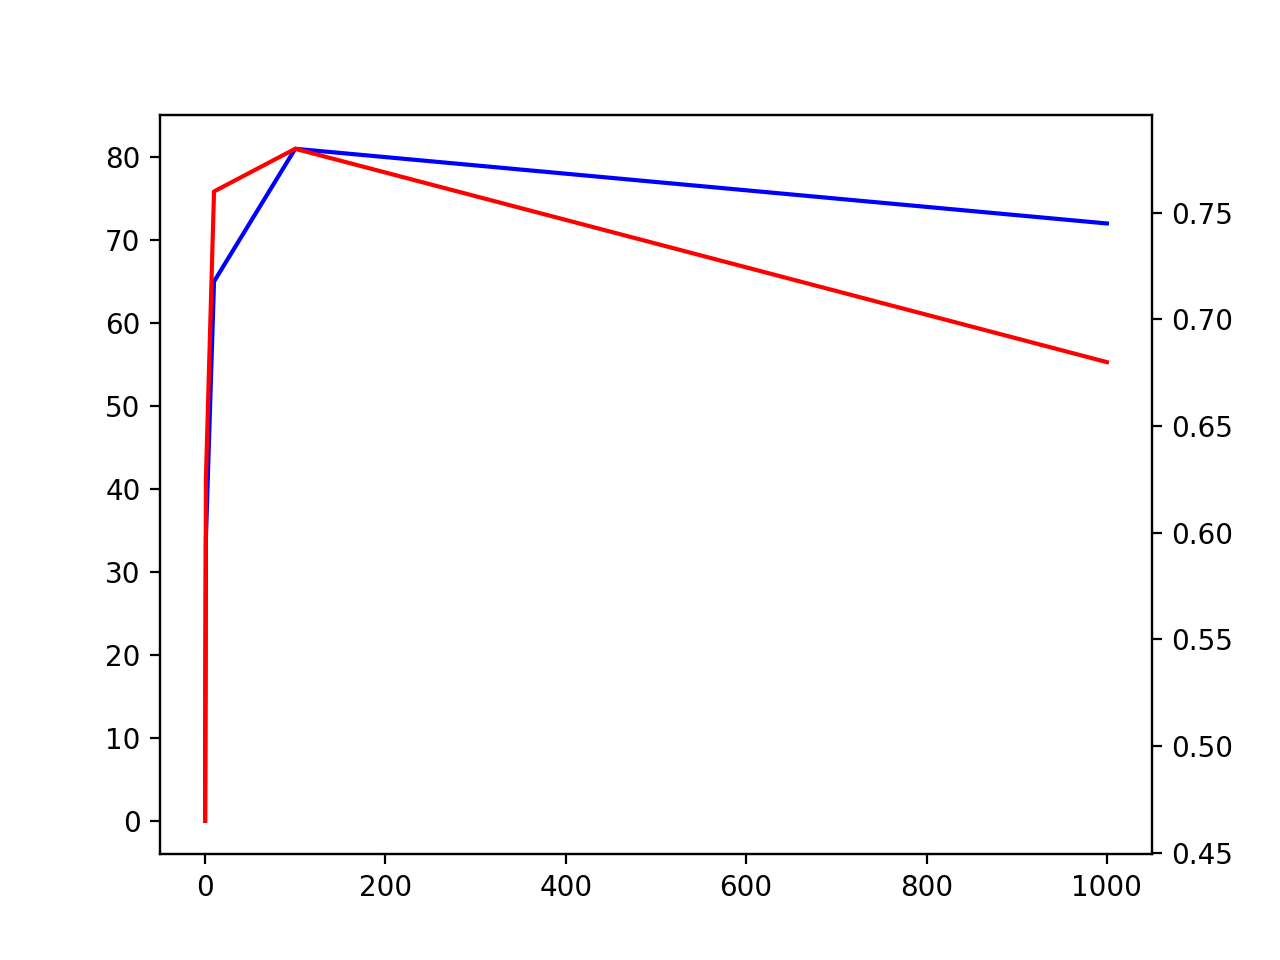

In [19]:
fig, ax = plt.subplots()

ax.plot(Cs, no_nos, "b")

ax2 =ax.twinx()
ax2.plot(Cs, accuracies, "r")

plt.show()

The `C` parameter should be optimal somewhere above 100.


In [20]:
no_nos = []
accuracies = []
Cs = range(100, 2000)

clf.set_params(probability=False)

for c in tqdm(Cs):
    clf.set_params(C=c)
    clf.fit(training_data, training_labels)
    
    accuracies.append(clf.score(testing_data, testing_labels)) 
    no_nos.append(confusion_matrix(testing_labels, clf.predict(testing_data))[0][0])

100%|██████████| 1900/1900 [09:16<00:00,  3.53it/s]


<IPython.core.display.Javascript object>


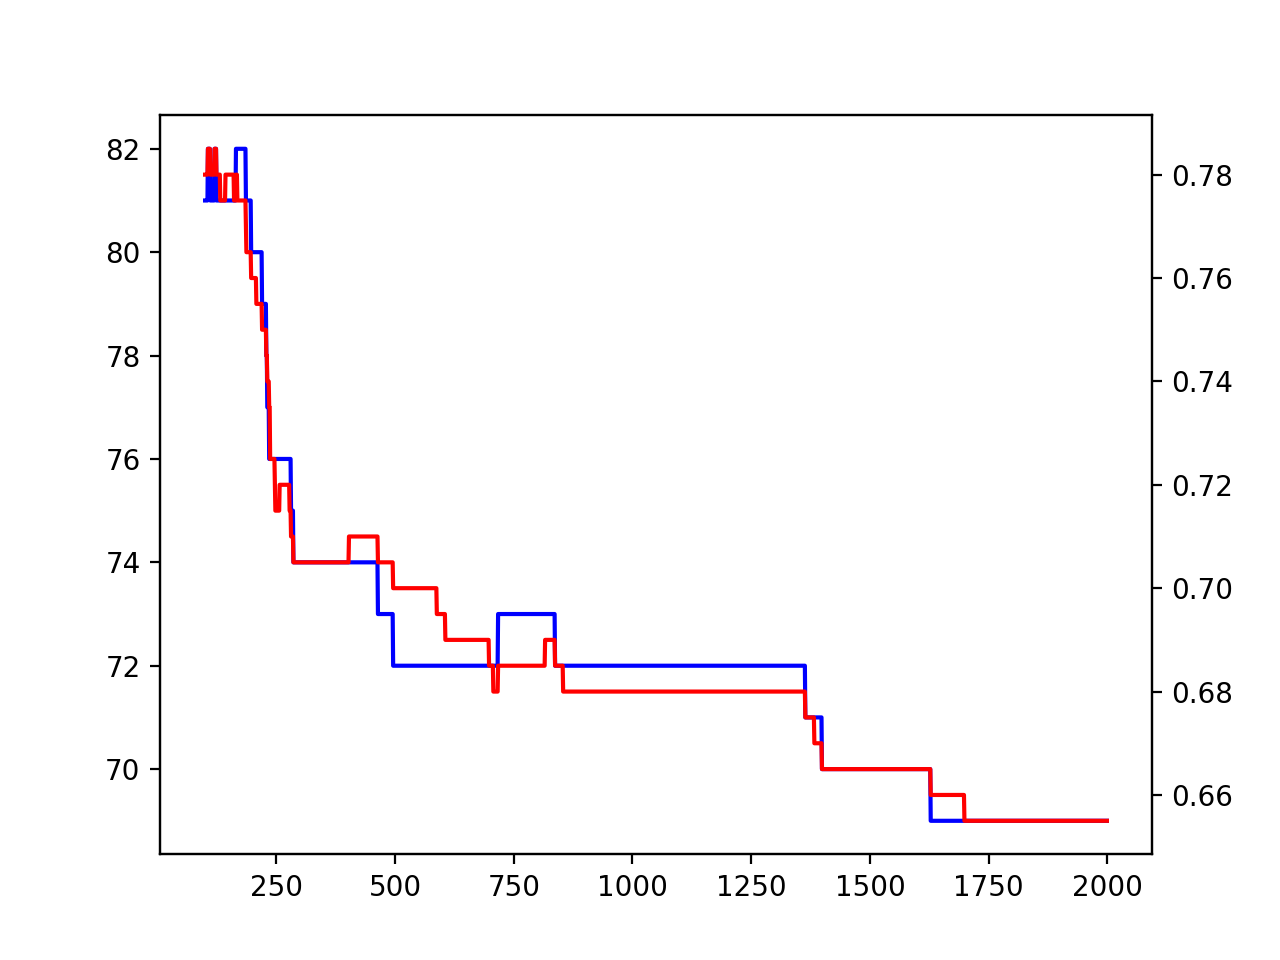

In [21]:
fig, ax = plt.subplots()

plot_cs = [c for c in Cs]

ax.plot(plot_cs, no_nos, "b")

ax2 =ax.twinx()
ax2.plot(plot_cs, accuracies, "r")

plt.show()

<IPython.core.display.Javascript object>


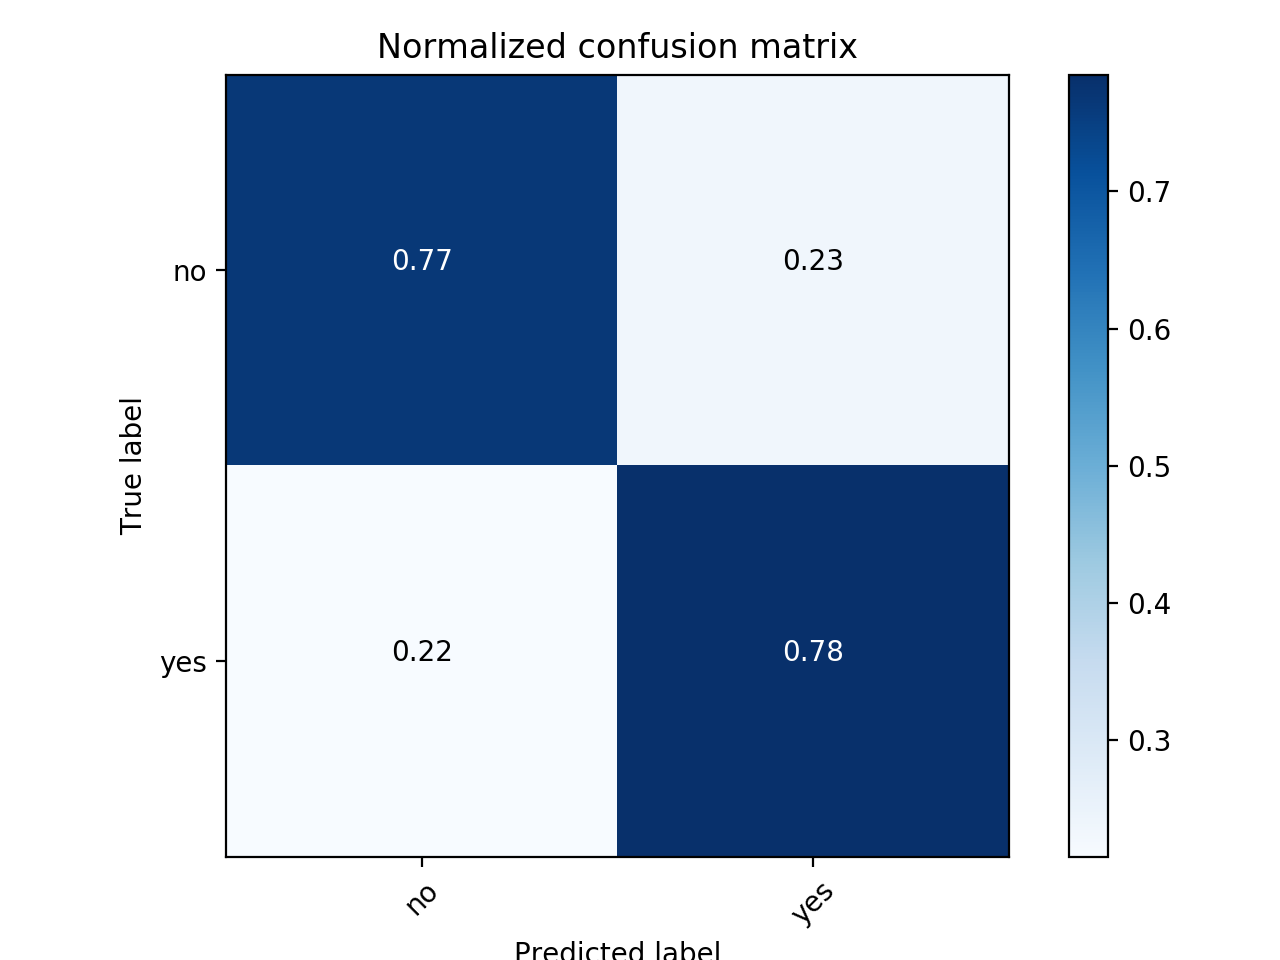

Normalized confusion matrix
[[0.77 0.23]
 [0.22 0.78]]


In [22]:
clf.set_params(C=177)
clf.fit(training_data, training_labels)

show_confusion_matrix(testing_labels, clf.predict(testing_data))

We built a model that is write 3 times out of 4 on average for both classes.

But another model can be found that will identify « yes. » 98 times out of 100, but will perform really bad on « no. ». It really depends of what the model will be used for.



<IPython.core.display.Javascript object>


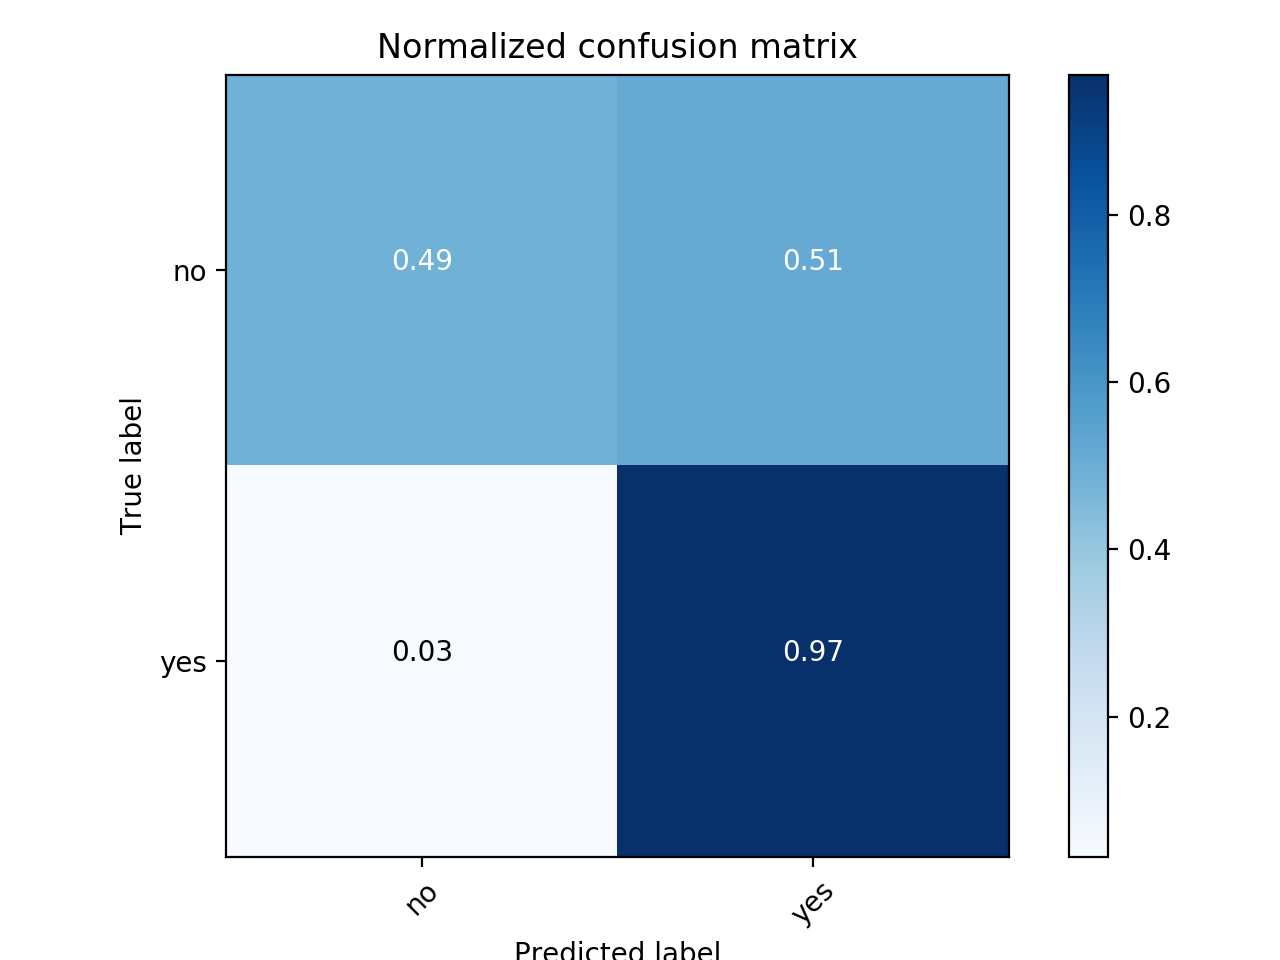

Normalized confusion matrix
[[0.49 0.51]
 [0.03 0.97]]


In [23]:
clf.set_params(C=3)
clf.fit(training_data, training_labels)

show_confusion_matrix(testing_labels, clf.predict(testing_data))